In [52]:
# For some reason the learning tends to be better with fastai, even though I did not use any specific functions from fastai. 
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [53]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [54]:
#added to get around stupid admin approval
import ssl, certifi
ssl._create_default_https_context = lambda *args, **kwargs: ssl.create_default_context(cafile=certifi.where())


# Data from patients with primary invasive breast cancer
This study examined tissue samples from patients with primary invasive breast cancer, including four major tumor subtypes: triple-negative (TN) (41 cases), HER2-positive (30 cases), luminal A (29 cases), and luminal B (30 cases). Tumor samples were collected during surgery, before patients received any form of treatment, to ensure that gene activity reflected the natural biology of the tumors. For comparison, samples from 11 normal breast tissue as well as 14 established breast cancer cell lines were also included. ***RNA, the molecule that reflects which genes are active in a cell, was extracted from all samples***. Gene activity across the entire genome was then measured using Affymetrix U133 Plus 2.0 microarray technology.

| Sample type   | Purpose                                            |
| ------------- | -------------------------------------------------- |
| Tumors        | Define subtype-specific cancer expression profiles |
| Normal tissue | Identify cancer-specific changes                   |
| Cell lines    | Enable experimental follow-up and model validation |


We obtained the data from National Institutes of Health (NIH), the National Center for Biotechnology Information, which is available at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE45827.

In [55]:
import gzip
import pandas as pd
import urllib.request
from pathlib import Path

url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE45nnn/GSE45827/matrix/GSE45827_series_matrix.txt.gz"
path = Path("GSE45827_series_matrix.txt.gz")      # make sure that the file is saved in the same directory.

if not path.exists():
   urllib.request.urlretrieve(url, path)

# Data format from NCBI GEO
Data format: *NCBI GEO (Gene Expression Omnibus)*

File type: Series Matrix

We follow the NCBI GEO data format below: *"!series_matrix_table_begin"* (respectively, *"!series_matrix_table_end"*) is a standard marker defined by NCBI GEO, used in GEO Series Matrix files (*_series_matrix.txt) to mark the beginning of the expression data table.

We import the data directly from the path.

In [56]:
with gzip.open(path, "rt") as f:
    lines = f.readlines()

# Find where expression data starts
start = [i for i, l in enumerate(lines) if l.startswith("!series_matrix_table_begin")][0] + 1
end = [i for i, l in enumerate(lines) if l.startswith("!series_matrix_table_end")][0]

# "\t" for tab-separated data table
data = pd.read_csv(
    path,
    sep="\t",
    skiprows=start,
    nrows=end - start
)


# A suitable data frame
We use 'data.set_index(data.columns[0])' and return a new DataFrame (see the table below). After transpose, the first column of X is the sample ID (e.g., GSM1116084, GSM1116085, etc.) and the first row is the probe IDs (e.g., 1007_s_at, 1053_at, etc.): Probe IDs are identifiers for the physical DNA probes used on a microarray chip (measurement units) to detect gene expression. They are not genes themselves, but measurement instruments designed to detect genes. That is to say, they are not gene names but proxies for them. Here are more detailed meaning of each suffix of probe IDs.  


| Suffix  | Meaning            | Biological implication                                  |
| ------- | ------------------ | --------------------------------------------------------|
| `_at`   | Standard probe set | Targets a specific transcript; generally most reliable  |
| `_s_at` | Similar            | May hybridize to multiple transcripts of related genes  |
| `_x_at` | Cross-hybridizing  | Can bind unrelated transcripts (noisy and less reliable)|
| `_a_at` | Alternative        | Targets alternative splice variants                     |
| `_r_at` | Revised            | Updated mapping                                         |
| `_i_at` | Intron-based       | Measures pre-mRNA / transcriptional activity            |



In [57]:
# First column is gene ID.
data = data.set_index(data.columns[0])

# Transpose: samples × genes
X = data.T

# number of (samples x genes) 
X.shape

(155, 29874)

In [58]:
# X.head() shows the first (default=5) rows; same as X[0:5]
X.head()


ID_REF,1007_s_at,1053_at,117_at,1294_at,1316_at,1405_i_at,1438_at,1487_at,1552256_a_at,1552257_a_at,1552258_at,1552263_at,1552264_a_at,1552266_at,1552274_at,1552275_s_at,1552277_a_at,1552279_a_at,1552283_s_at,1552286_at,1552287_s_at,1552288_at,1552289_a_at,1552291_at,1552295_a_at,1552301_a_at,1552302_at,1552303_a_at,1552306_at,1552307_a_at,1552309_a_at,1552310_at,1552311_a_at,1552312_a_at,1552315_at,1552316_a_at,1552318_at,1552319_a_at,1552325_at,1552327_at,1552329_at,1552330_at,1552332_at,1552334_at,1552343_s_at,1552344_s_at,1552347_at,1552348_at,1552349_a_at,1552360_a_at,1552362_a_at,1552364_s_at,1552365_at,1552367_a_at,1552370_at,1552378_s_at,1552383_at,1552389_at,1552390_a_at,1552398_a_at,1552399_a_at,1552417_a_at,1552423_at,1552426_a_at,1552427_at,1552467_at,1552472_a_at,1552473_at,1552474_a_at,1552477_a_at,1552478_a_at,1552482_at,1552485_at,1552486_s_at,1552496_a_at,1552502_s_at,1552504_a_at,1552507_at,1552508_at,1552509_a_at,1552516_a_at,1552518_s_at,1552519_at,1552532_a_at,1552536_at,1552542_s_at,1552573_s_at,1552575_a_at,1552578_a_at,1552584_at,1552602_at,1552610_a_at,1552611_a_at,1552612_at,1552613_s_at,1552617_a_at,1552618_at,1552619_a_at,1552621_at,1552622_s_at,1552623_at,1552625_a_at,1552626_a_at,1552627_a_at,1552628_a_at,1552632_a_at,1552633_at,1552634_a_at,1552639_at,1552641_s_at,1552643_at,1552644_a_at,1552648_a_at,1552656_s_at,1552658_a_at,1552660_a_at,1552663_a_at,1552664_at,1552670_a_at,1552671_a_at,1552677_a_at,1552678_a_at,1552680_a_at,1552685_a_at,1552691_at,1552696_at,1552701_a_at,1552703_s_at,1552711_a_at,1552716_at,1552717_s_at,1552719_at,1552727_s_at,1552729_at,1552733_at,1552735_at,1552738_a_at,1552739_s_at,1552740_at,1552749_a_at,1552766_at,1552767_a_at,1552769_at,1552770_s_at,1552779_a_at,1552782_at,1552783_at,1552787_at,1552789_at,1552790_a_at,1552797_s_at,1552801_at,1552807_a_at,1552829_at,1552846_s_at,1552848_a_at,1552862_at,1552867_at,1552889_a_at,1552899_at,1552914_a_at,1552921_a_at,1552930_at,1552931_a_at,1552937_s_at,1552961_at,1552974_at,1552975_x_at,1552977_a_at,1552978_a_at,1552980_at,1553011_at,1553015_a_at,1553030_a_at,1553034_at,1553043_a_at,1553047_at,1553048_a_at,1553055_a_at,1553072_at,1553096_s_at,1553099_at,1553101_a_at,1553102_a_at,1553103_at,1553105_s_at,1553106_at,1553108_at,1553111_a_at,1553112_s_at,1553113_s_at,1553114_a_at,1553117_a_at,1553118_at,1553122_s_at,1553130_at,1553132_a_at,1553139_s_at,1553142_at,1553145_at,1553148_a_at,1553150_at,1553165_at,1553172_at,1553185_at,1553186_x_at,1553193_at,1553199_at,1553202_at,1553214_a_at,1553216_at,1553218_a_at,1553225_s_at,1553227_s_at,1553229_at,1553243_at,1553248_at,1553252_a_at,1553255_at,1553261_x_at,1553269_at,1553271_at,1553274_a_at,1553275_s_at,1553280_at,1553286_at,1553292_s_at,1553297_a_at,1553338_at,1553348_a_at,1553349_at,1553359_at,1553361_x_at,1553394_a_at,1553396_a_at,1553400_a_at,1553402_a_at,1553407_at,1553410_a_at,1553413_at,1553423_a_at,1553430_a_at,1553434_at,1553436_at,1553438_at,1553462_at,1553474_at,1553493_a_at,1553510_s_at,1553528_a_at,1553530_a_at,1553535_a_at,1553538_s_at,1553542_at,1553551_s_at,1553567_s_at,1553569_at,1553570_x_at,1553575_at,1553581_s_at,1553583_a_at,1553587_a_at,1553588_at,1553589_a_at,1553602_at,1553603_s_at,1553611_s_at,1553612_at,1553613_s_at,1553614_a_at,1553622_a_at,1553663_a_at,1553668_at,1553672_at,1553677_a_at,1553678_a_at,1553679_s_at,1553681_a_at,1553685_s_at,1553689_s_at,1553691_at,1553693_s_at,1553694_a_at,1553696_s_at,1553698_a_at,1553703_at,1553704_x_at,1553705_a_at,1553706_at,1553709_a_at,1553713_a_at,1553715_s_at,1553718_at,1553719_s_at,1553720_a_at,1553725_s_at,1553726_s_at,1553728_at,1553732_s_at,1553743_at,1553749_at,1553750_a_at,1553759_at,1553764_a_at,1553768_a_at,1553780_at,1553797_a_at,1553798_a_at,1553801_a_at,1553803_at,1553830_s_at,1553856_s_at,1553857_at,1553858_at,1553868_a_at,1553882_at,1553901_x_at,1553906_s_at,1553909_x_at,1553910_at,1553928_at,1553940_a_at,1553946_at,1553947_at,1553954_at,1553955_at,1553956_at,1553957_at,1553959_a_at,1553960_at,1553961_s_

The values of the table for given sample IDs and probe IDs represent gene-expression level — specifically, normalized microarray signal intensities measured by each probe for each sample. More precisely, in a microarray experiment,
a chip contains millions of short DNA sequences fixed on a surface. ***Each short DNA sequence in a chip is called a probe. Probes bind (“hybridize”) to matching RNA (cDNA) from a sample. And the amount of binding is called the expression level.*** A Probe ID is just a name given to a specific probe or probe set on the chip.


The data were first normalized by using GC-RMA (R version 2.14.1). A linear mixed model using Restricted Maximum Likelihood (REML using name package) was then applied. The model included the different experimental batches and the sample type as fixed effects, and treated technical variation as random effects. No interaction terms were included. This model was used to derive significance for differential expression between different tumor types and for correction of batch and hybridization effects. For further analysis, technical replicates were averaged. We choose to discard probe-sets with noise-level signal from the analysis: specifically, we considered as not expressed and therefore discarded, all the probe-sets with a log2 intensity of less than 4 in 95% or more of tissue samples (see https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1116084 for the first sample with ID GSM1116084).

***The data pre-processing is standard and should be compatible with Stochastic gradient descent(SGD) and Adam optimizer.***   

# Labels for training 

In [59]:
# Extract phenotype lines
pheno_lines = [l for l in lines if l.startswith("!Sample_source_name_ch1")]

labels = []
for line in pheno_lines:
    parts = line.strip().split("\t")[1:]
    labels = parts
    
# In total there are 155 labels.
# 

labels[:5]

['"Human Basal Tumor Sample"',
 '"Human Basal Tumor Sample"',
 '"Human Her2 Tumor Sample"',
 '"Human Basal Tumor Sample"',
 '"Human Her2 Tumor Sample"']

In [60]:
yy = pd.Series(labels)
set(yy)

{'"Human Basal Tumor Sample"',
 '"Human CellLine"',
 '"Human Her2 Tumor Sample"',
 '"Human Luminal A Tumor Sample"',
 '"Human Luminal B Tumor Sample"',
 '"Human Normal"'}

In [61]:
# Returns 1=true if the label contains 'tumor' and returns 0=false otherwise
y = pd.Series(labels).str.lower().str.contains("tumor").astype(int).values

In [62]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

As it shows above, there are 6 distinct labels: "Human Basal Tumor Sample", "Human CellLine", "Human Her2 Tumor Sample", "Human Luminal A Tumor Sample", "Human Luminal B Tumor Sample", "Human Normal". Now we assign boolean value to the labels which contain the word "tumor" to train the machine to study to give the right conclusions matching with the label. 

# To initiate training
## Basic set-up for learning using two different methods: Stochastic gradient descent(SGD) and Adam optimizer.

Now we convert to torch.

In [63]:
import torch

# X is a pandas DataFrame here
X_df = X.copy()

X_df = (X_df - X_df.mean(axis=0)) / X_df.std(axis=0)
X_df = X_df.fillna(0.0)

# now convert to torch
X = torch.tensor(X_df.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)



In [64]:
X.shape

torch.Size([155, 29874])

In [65]:
n = len(X)
# The function randperm(n) generates a random ordering of integers from 1 to n
idx = torch.randperm(n)

train_idx = idx[:int(0.8*n)]
valid_idx = idx[int(0.8*n):]

train_x, train_y = X[train_idx], y[train_idx]
valid_x, valid_y = X[valid_idx], y[valid_idx]


In [66]:
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

(torch.Size([124, 29874]),
 torch.Size([31, 29874]),
 torch.Size([124]),
 torch.Size([31]))

# Principal Component Analysis

In [67]:
torch.pca_lowrank(train_x), torch.pca_lowrank(train_x)[0].shape, torch.pca_lowrank(train_x)[1].shape, torch.pca_lowrank(train_x)[2].shape

((tensor([[-1.8702e-01, -1.0155e-01, -7.9610e-02, -6.4024e-03, -3.6272e-02, -2.7467e-03],
          [-6.3202e-02, -5.2889e-03,  1.1427e-01,  6.0287e-03, -3.0598e-01, -1.8257e-01],
          [ 3.0549e-02,  2.4185e-03,  6.9856e-03, -1.7663e-02,  1.2925e-01, -8.8548e-02],
          [ 7.2224e-02,  6.2185e-02, -6.3275e-02,  1.6441e-01,  5.5989e-02, -2.4948e-03],
          [-6.8594e-02,  1.3286e-02,  1.3693e-01,  4.4482e-02, -1.1316e-01, -4.0488e-03],
          [ 6.5268e-02,  4.8375e-02, -1.4602e-01, -1.1247e-02, -1.2945e-01,  7.3714e-02],
          [ 2.0729e-01, -3.2557e-01,  1.2042e-01, -7.0484e-02, -1.4722e-01, -4.0424e-02],
          [ 4.4190e-02,  7.2609e-02, -1.0564e-01,  5.4344e-02, -9.2839e-02,  2.6080e-02],
          [-2.3730e-02,  4.3053e-02, -5.1623e-03, -1.4182e-01,  3.7185e-02, -6.5025e-02],
          [ 9.2159e-02,  2.5676e-02, -1.3271e-01, -1.1240e-01, -4.2212e-02,  6.7519e-02],
          [ 6.9305e-02,  6.1438e-02, -4.0623e-02,  6.1010e-02, -7.4483e-02,  3.8007e-02],
          

In [68]:
# We use sklearn for PCA and modify the PyTorch tensor to the right format to use sklearn

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# What is n_components in PCA? How can we choose optimal n_components?

pca = PCA(n_components=85)


In [69]:
X_np = train_x.detach().cpu().numpy()
X_pca = pca.fit_transform(X_np)
X_pca

array([[-138.76828   ,   60.94807   ,  -34.922848  , ...,   -4.8280163 ,    3.747296  ,    5.3136177 ],
       [ -46.852028  ,    5.232403  ,   51.35608   , ...,  -12.24516   ,   -3.3434129 ,   -0.43546516],
       [  22.71337   ,   -1.0230379 ,    2.5971117 , ...,   -0.46953362,    9.855559  ,   -6.439301  ],
       ...,
       [  46.32173   ,  -50.965935  ,  -27.594698  , ...,  -11.942334  ,    2.8572748 ,    9.877117  ],
       [  21.819256  ,  -21.478844  ,  -29.003523  , ...,   -5.820728  ,   17.924707  ,   -8.420877  ],
       [  71.14641   ,  -15.932606  ,  -32.50027   , ...,   11.295477  ,   -1.7225494 ,  -10.236787  ]], shape=(124, 85), dtype=float32)

In [70]:
X_pca.shape

(124, 85)

In [71]:
pca.explained_variance_ratio_.cumsum()

array([0.14884228, 0.24190065, 0.299928  , 0.33782107, 0.3698371 , 0.397121  , 0.41853812, 0.43747416, 0.4537675 , 0.46906373, 0.48285103, 0.49651846, 0.50872356, 0.5207926 , 0.53209835, 0.5429325 ,
       0.55357105, 0.5639265 , 0.57404673, 0.58356947, 0.59290344, 0.6018485 , 0.61028695, 0.6184562 , 0.6264981 , 0.63439727, 0.6420918 , 0.64960533, 0.6570084 , 0.6641948 , 0.67127836, 0.67821646,
       0.684958  , 0.69151556, 0.69791025, 0.70417005, 0.7103404 , 0.71642965, 0.72248423, 0.7284541 , 0.7343285 , 0.7399985 , 0.7456432 , 0.7512127 , 0.7566165 , 0.7619556 , 0.7672538 , 0.7724025 ,
       0.7775174 , 0.7825486 , 0.7874879 , 0.792284  , 0.7970576 , 0.8017199 , 0.8061778 , 0.8105771 , 0.81491554, 0.81922114, 0.82351446, 0.82771385, 0.8318479 , 0.8359393 , 0.83996093, 0.84392047,
       0.8478103 , 0.85166967, 0.8554704 , 0.8591918 , 0.86287415, 0.8664809 , 0.87008584, 0.87359273, 0.8770493 , 0.8804807 , 0.8838248 , 0.8871281 , 0.89038515, 0.8935707 , 0.89670795, 0.899798  ,
     

In [72]:
pca.fit(X_pca)
X_pca.shape, X_pca

((124, 85),
 array([[-138.76828   ,   60.94807   ,  -34.922848  , ...,   -4.8280163 ,    3.747296  ,    5.3136177 ],
        [ -46.852028  ,    5.232403  ,   51.35608   , ...,  -12.24516   ,   -3.3434129 ,   -0.43546516],
        [  22.71337   ,   -1.0230379 ,    2.5971117 , ...,   -0.46953362,    9.855559  ,   -6.439301  ],
        ...,
        [  46.32173   ,  -50.965935  ,  -27.594698  , ...,  -11.942334  ,    2.8572748 ,    9.877117  ],
        [  21.819256  ,  -21.478844  ,  -29.003523  , ...,   -5.820728  ,   17.924707  ,   -8.420877  ],
        [  71.14641   ,  -15.932606  ,  -32.50027   , ...,   11.295477  ,   -1.7225494 ,  -10.236787  ]], shape=(124, 85), dtype=float32))

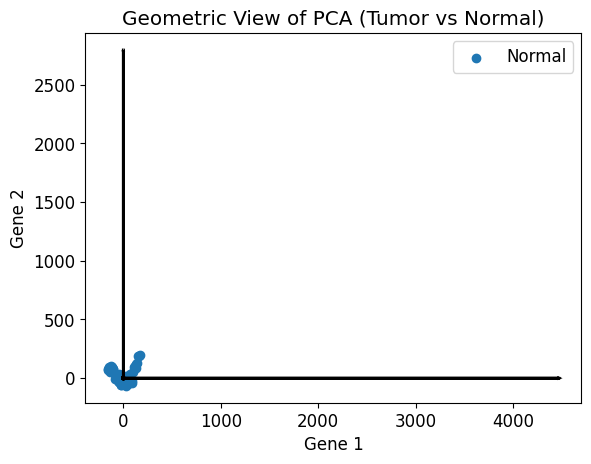

In [73]:
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], label="Normal")
# plt.scatter(tumor[:, 0], tumor[:, 1], label="Tumor")

# Plot principal components as arrows
origin = X_pca.mean(axis=0)
for var, vec in zip(pca.explained_variance_, pca.components_):
    plt.arrow(
        origin[0], origin[1],
        vec[0] * var,
        vec[1] * var,
        linewidth=2,
        head_width=0.1
    )

plt.xlabel("Gene 1")
plt.ylabel("Gene 2")
plt.title("Geometric View of PCA (Tumor vs Normal)")
plt.legend()
plt.show()

# Train the model using SGD and Adam optimizer

In [83]:
from torch.utils.data import DataLoader
from fastai.data.core import DataLoaders


bs = 32

train_dl = DataLoader(list(zip(train_x, train_y)), batch_size=bs, shuffle=True)
valid_dl = DataLoader(list(zip(valid_x, valid_y)), batch_size=bs)

# dls = DataLoaders(train_dl, valid_dl)




In [84]:
import torch.nn as nn
from torch.optim import SGD, Adam

# model = nn.Linear(X.shape[1], 1)
loss_func = nn.BCEWithLogitsLoss()


Tumor samples have label y = 1
Normal samples have label y = 0. 
Thus we use the linear model
$$z=w^⊤ x+b,$$
where the weight $w=(w_1,w_2, \ldots, w_m)$ has the number of entries which corresponds to the number of probes $m$ and $b$ represents bias. The way that we defined the label, the signs and the absolute value of the weights suggest the following:
* $w_i>0$: higher expression pushes toward tumor;
* $w_i<0$: higher expression pushes toward normal;
* Large $|w_i|$: this probe contributes strongly to the decision direction;
* Small $|w_i|$: this probe carries no predictive signal.

As we are building a model which can perform a binary classification, i.e., whether a given sample has tumor (value 1) or normal (value 0), we use the nn.BCEWithLogitLoss() loss function. 
Binary cross-entropy is defined per sample:

$$\ell(x, y)
= -\big[ y \log p(x) + (1 - y)\log(1 - p(x)) \big],$$
where $p(x)=P(y=1|x)=\sigma(w^⊤ x+b)$, and $\sigma$ is the sigmoid function.
And the model objective is the average loss over 
$N$ elements ($N$ is the batch size.):
$$L
= \frac{1}{N} \sum_{i=1}^{N} \ell(x_i, y_i)$$


In [85]:
def batch_accuracy(preds, y, thresh=0.7):
    return ((preds.sigmoid() > thresh) == y).float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

## Adding nonlinearity to the model
We quickly recall nn.Sequential, a container module in PyTorch designed to stack neural network layers in a specific, ordered sequence. 
```python \n
model = nn.Sequential(
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)
```
$$x\rightarrow \text{layer 1} \rightarrow \text{layer 2} \rightarrow \text{layer 3} \rightarrow output$$

Then calling model(x) is equivalent to

```python \n
x = nn.Linear(100,50)(x)
x = nn.ReLU()(x)
x = nn.Linear(50,1)(x)
```

## Three layers and the change of the shape of the input

We add Fully-connected layer to improve our model. In particular, we updated the linear model using ```.ReLU()```. We add three layers as follows: 
```python \n
model = nn.Sequential(
        nn.Linear(X.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
        )
```
We defined previously train_dl, the dataloader with batch size (bs=32) as follows.
```python \n
train_dl = DataLoader(list(zip(train_x, train_y)), batch_size=bs, shuffle=True)
```
Then the shape of the input through each layer of the ```model``` changes as follows.
* xb in train_dl is a tensor with shape [32,29874], where 32 is the batch size (```bs```), and 29874 is the number of probes ```X.shape[1]```;
* ``` x = nn.Linear(X.shape[1],64)(xb)``` results a tensor with shape [32,64];
* ``` x = nn.ReLU()(x)``` results a tensor with shape [32,64];
* ``` x = nn.Linear(64,1)``` results a tensor with shape [32,1].
* ``` x.squeeze()``` results a tensor with shape [32] which matches with the shape of ```yb``` to compute the loss.


In [86]:
# For both SGD and the Adam optimizer

def train_model(opt, epochs=20):
    
    model = nn.Sequential(
        nn.Linear(X.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )
    
#   We had previously only the following single layer     
#   model = nn.Linear(X.shape[1], 1) 
#   With the single-layer model, model(xb) is of torch size model(xb).shape=[28,1] and yb is of torch size [28]


    # The folloing line nstantiates the optimizer, passing it the model’s trainable parameters
    # opt = SGD(model.parameters()) is equivalent to train_model(SGD)
    opt = opt(model.parameters())

    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_dl:
            
            # Recall that loss_func = nn.BCEWithLogitsLoss()
            
            loss = loss_func(model(xb).squeeze(), yb)
            loss.backward()
            
            opt.step()
            opt.zero_grad()
            
            total_loss += loss.item()
            probs = model(valid_x).sigmoid()
        
        print(f"Epoch {epoch}: loss={total_loss:.3f}, acc={validate_epoch(model)}", model(xb).shape)
        print(probs.min().item(), probs.max().item(), probs.mean().item())
    
    return model

Note that we have 124 pairs in ```train_dl```.

In [87]:
for xb, yb in train_dl:
    print(xb.shape[0])

32
32
32
28


In [88]:


print("=== SGD ===")
model_sgd = train_model(
    lambda params: SGD(params, lr=0.01, weight_decay=1e-3)
)

# lambda became SGD(model.parameters(), lr=0.01, weight_decay=1e-3)


print("\n=== Adam ===")
model_adam = train_model(
    lambda params: Adam(params, lr=1e-3, weight_decay=1e-3)
)



=== SGD ===
Epoch 0: loss=1.969, acc=0.6316 torch.Size([28, 1])
0.004855928476899862 0.89055997133255 0.6470847725868225
Epoch 1: loss=0.726, acc=0.6795 torch.Size([28, 1])
0.0030700224451720715 0.9469972848892212 0.7209311127662659
Epoch 2: loss=0.401, acc=0.7274 torch.Size([28, 1])
0.002527500968426466 0.9659982323646545 0.7602751851081848
Epoch 3: loss=0.264, acc=0.7513 torch.Size([28, 1])
0.0020611686632037163 0.9757983684539795 0.7828009128570557
Epoch 4: loss=0.195, acc=0.7513 torch.Size([28, 1])
0.0017934376373887062 0.9812379479408264 0.7975504398345947
Epoch 5: loss=0.152, acc=0.7752 torch.Size([28, 1])
0.0015215941239148378 0.9847204685211182 0.8080697059631348
Epoch 6: loss=0.123, acc=0.7752 torch.Size([28, 1])
0.0013035390293225646 0.9872426986694336 0.8156937956809998
Epoch 7: loss=0.103, acc=0.7752 torch.Size([28, 1])
0.001142164459452033 0.9892129302024841 0.8215370774269104
Epoch 8: loss=0.087, acc=0.7752 torch.Size([28, 1])
0.0010284190066158772 0.9909566044807434 0.82

In [24]:
y.mean()

tensor(0.8387)

# Learning with data filtered by the PCA 
We use SGD+ReLU (same as above) on the data filtered by the PCA.

In [95]:
train_x_pca = pca.fit_transform(train_x)   # (124, 85)
valid_x_pca = pca.transform(valid_x)

In [96]:
train_x_pca = torch.tensor(train_x_pca, dtype=torch.float32)
valid_x_pca = torch.tensor(valid_x_pca, dtype=torch.float32)

In [97]:
X_pca = torch.tensor(X_pca)
# X_pca = X_pca.detach().clone()
X_pca.shape

/var/folders/tt/944h4xl91ll9w1sjmrxxzcmr0000gq/T/ipykernel_29410/2532473359.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_pca = torch.tensor(X_pca)


torch.Size([124, 85])

In [98]:
bs = 32

train_dl = DataLoader(list(zip(train_x, train_y)), batch_size=bs, shuffle=True)
valid_dl = DataLoader(list(zip(valid_x, valid_y)), batch_size=bs)

# dls = DataLoaders(train_dl, valid_dl)


In [99]:

train_dl = DataLoader(
    list(zip(train_x_pca, train_y)),
    batch_size=bs,
    shuffle=True
)

valid_dl = DataLoader(
    list(zip(valid_x_pca, valid_y)),
    batch_size=bs
)

In [100]:
loss_func = nn.BCEWithLogitsLoss()

def batch_accuracy(preds, y, thresh=0.7):
    return ((preds.sigmoid() > thresh) == y).float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [101]:
train_x_pca.shape, valid_x_pca.shape, train_y.shape, valid_y.shape

(torch.Size([124, 85]),
 torch.Size([31, 85]),
 torch.Size([124]),
 torch.Size([31]))

In [102]:
# For both SGD and the Adam optimizer

def train_model_PCA(opt, epochs=20):
    
    model = nn.Sequential(
        nn.Linear(X_pca.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )
    
#   We had previously only the following single layer     
#   model = nn.Linear(X.shape[1], 1) 
#   With the single-layer model, model(xb) is of torch size model(xb).shape=[28,1] and yb is of torch size [28]


    # The folloing line nstantiates the optimizer, passing it the model’s trainable parameters
    # opt = SGD(model.parameters()) is equivalent to train_model(SGD)
    opt = opt(model.parameters())

    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_dl:
            
            # Recall that loss_func = nn.BCEWithLogitsLoss()
            
            loss = loss_func(model(xb).squeeze(), yb)
            loss.backward()
            
            opt.step()
            opt.zero_grad()
            
            total_loss += loss.item()
            probs = model(valid_x_pca).sigmoid()
        
        print(f"Epoch {epoch}: loss={total_loss:.3f}, acc={validate_epoch(model)}", model(xb).shape)
        print(probs.min().item(), probs.max().item(), probs.mean().item())
    
    return model

In [82]:
print("=== SGD ===")
model_sgd = train_model_PCA(
    lambda params: SGD(params, lr=0.01)
)

# lambda became SGD(model.parameters(), lr=0.01, weight_decay=1e-3)


print("\n=== Adam ===")
model_adam = train_model_PCA(
    lambda params: Adam(params, lr=1e-3)
)


=== SGD ===
Epoch 0: loss=2.955, acc=0.7752 torch.Size([28, 1])
0.005009816028177738 0.9997696280479431 0.8460678458213806
Epoch 1: loss=0.555, acc=0.7513 torch.Size([28, 1])
0.00020889424195047468 0.9996864795684814 0.8226011991500854
Epoch 2: loss=0.159, acc=0.7274 torch.Size([28, 1])
6.117494194768369e-05 0.99972003698349 0.8245567083358765
Epoch 3: loss=0.096, acc=0.7752 torch.Size([28, 1])
6.641063373535872e-05 0.99978107213974 0.8357754349708557
Epoch 4: loss=0.069, acc=0.7752 torch.Size([28, 1])
4.963192259310745e-05 0.9998111128807068 0.840007483959198
Epoch 5: loss=0.056, acc=0.7752 torch.Size([28, 1])
3.9602276956429705e-05 0.9998326301574707 0.8429758548736572
Epoch 6: loss=0.047, acc=0.7752 torch.Size([28, 1])
3.4203974792035297e-05 0.9998496770858765 0.8450615406036377
Epoch 7: loss=0.040, acc=0.7752 torch.Size([28, 1])
2.8788292183890007e-05 0.9998714923858643 0.8467205166816711
Epoch 8: loss=0.036, acc=0.7752 torch.Size([28, 1])
2.1697585907531902e-05 0.999886155128479 0

In [103]:
def train_model_PCA_nonReLU(opt, epochs=20):
    
    model = nn.Linear(X_pca.shape[1], 1) 

    
#   We had previously only the following single layer     
#   
#   With the single-layer model, model(xb) is of torch size model(xb).shape=[28,1] and yb is of torch size [28]


    # The folloing line nstantiates the optimizer, passing it the model’s trainable parameters
    # opt = SGD(model.parameters()) is equivalent to train_model(SGD)
    opt = opt(model.parameters())

    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_dl:
            
            # Recall that loss_func = nn.BCEWithLogitsLoss()
            
            loss = loss_func(model(xb).squeeze(), yb)
            loss.backward()
            
            opt.step()
            opt.zero_grad()
            
            total_loss += loss.item()
            probs = model(valid_x_pca).sigmoid()
        
        print(f"Epoch {epoch}: loss={total_loss:.3f}, acc={validate_epoch(model)}", model(xb).shape)
        print(probs.min().item(), probs.max().item(), probs.mean().item())
    
    return model

In [106]:
print("=== SGD ===")
model_sgd = train_model_PCA_nonReLU(
    lambda params: SGD(params, lr=0.01)
)

# lambda became SGD(model.parameters(), lr=0.01, weight_decay=1e-3)


print("\n=== Adam ===")
model_adam = train_model_PCA_nonReLU(
    lambda params: Adam(params, lr=1e-3)
)

=== SGD ===
Epoch 0: loss=7.619, acc=0.6316 torch.Size([28, 1])
3.46657431912234e-17 0.9999995231628418 0.7112236022949219
Epoch 1: loss=1.841, acc=0.7034 torch.Size([28, 1])
8.960119955731522e-22 1.0 0.8134751319885254
Epoch 2: loss=0.425, acc=0.7752 torch.Size([28, 1])
3.0872420139235532e-21 0.9999998807907104 0.8539705872535706
Epoch 3: loss=0.105, acc=0.7752 torch.Size([28, 1])
9.521935332832891e-21 0.9999997615814209 0.858691930770874
Epoch 4: loss=0.036, acc=0.7752 torch.Size([28, 1])
6.128318221599341e-21 0.9999998807907104 0.8606163859367371
Epoch 5: loss=0.027, acc=0.7752 torch.Size([28, 1])
3.812365987228583e-21 0.9999998807907104 0.8609932661056519
Epoch 6: loss=0.021, acc=0.7752 torch.Size([28, 1])
2.4773493890466316e-21 0.9999998807907104 0.8611395955085754
Epoch 7: loss=0.019, acc=0.7752 torch.Size([28, 1])
1.7428334018871085e-21 0.9999998807907104 0.8611243367195129
Epoch 8: loss=0.016, acc=0.7752 torch.Size([28, 1])
1.3397424934711752e-21 0.9999998807907104 0.8611491918